In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Libs & Code

In [ ]:
!pip install scikit-learn-intelex
from sklearnex import patch_sklearn
patch_sklearn()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.3/137.3 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 9.9 MB/s eta 0:00:00


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [ ]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import NuSVR
from sklearn.base import clone
from sklearn.model_selection import KFold
from sklearn.preprocessing import *
from sklearn.metrics import *
from sklearn.decomposition import *
from sklearn.ensemble import *
from sklearn.linear_model import *
from collections.abc import Iterable

In [ ]:
class ModelStrategy(object):
    def __init__(self, regressor) -> None:
        self._regressors = regressor

    def get_regressors(self):
        return self._regressors

    def set_strategy(self, regressor) -> None:
        self._regressors = regressor

    def fit(self, X_train, Y_train) -> None:
        self._fitted_regressors = []
        if not isinstance(self._regressors, Iterable):
            # Single regressors for all
            for y_train in Y_train.T:
                regressor = clone(self._regressors, safe=True)
                # Fit and save all regressors
                regressor.fit(X_train, y_train)
                self._fitted_regressors.append(regressor)
        else:
            assert len(self._regressors) == len(Y_train.T), \
                "Length of regressor should be the same as outputs in data"
            # Multiple regressors
            for _regressor, y_train in zip(self._regressors, Y_train.T):
                regressor = clone(_regressor, safe=True)
                # Fit and save all regressors
                regressor.fit(X_train, y_train)
                self._fitted_regressors.append(regressor)

        self._regressors = self._fitted_regressors

    def fit_transform(self, X_train, Y_train):
        # Fit on data
        self.fit(X_train, Y_train)
        # Transfrom data to numpy array and return
        return self.transform(X_train)

    def transform(self, X):
        y_pred = []
        for regressor in self._fitted_regressors:
            # For each saved regressor predict an output value
            y_pred.append(regressor.predict(X))
        return np.stack(y_pred, axis=1)


class AdapterSGTM(object):
    def __init__(self, number_of_steps = 1000, verbose=0):
        self._gtm = MultiLabelGTM(number_of_steps = number_of_steps, center_of_mass = True, verbose=verbose)

    def fit(self, X_train) -> None:
        self._gtm.fit(X_train, X_train)

    def fit_transform(self, X_train):
        self._gtm.fit(X_train, X_train)
        return self._gtm.map_to_principal_component(X_train)
        # return self._gtm.predict(X_train)

    def transform(self, X):
        # return self._gtm.predict(X)
        self._gtm.predict(X)
        return self._gtm.map_to_principal_component(X)


def relative_root_mean_squared_error(y, y_pred):
    n = len(y) # update
    num = np.sum(np.square(y - y_pred)) / n  # update
    den = np.sum(np.square(y_pred))
    squared_error = num / den
    rrmse_loss = np.sqrt(squared_error)
    return rrmse_loss

def calculate_errors(y, y_pred):
    MaxError = max_error                         (y, y_pred)
    MedError = median_absolute_error             (y, y_pred)
    MAE = mean_absolute_error                    (y, y_pred)
    MSE = mean_squared_error                     (y, y_pred)
    RMSE = mean_squared_error                    (y, y_pred, squared=False)
    RRMSE = relative_root_mean_squared_error     (y, y_pred)
    R2 = r2_score                                (y, y_pred)

    return {
            'MaxError' : MaxError,
            'MedError' : MedError,
            'MAE' :      MAE,
            'MSE' :      MSE,
            'RMSE' :     RMSE,
            'RRMSE' :    RRMSE,
            'R2' :       R2}

class AveragesCalculator:
    def __init__(self, data):
        self.data = data

    def _split_data(self):
        splitted_data = {}

        for dictionary in self.data:
            for key, inner_dict in dictionary.items():
                if key not in splitted_data:
                    splitted_data[key] = []
                splitted_data[key].append(inner_dict)

        return splitted_data

    def _sum_values(self, data):
        sums = {}

        for key, values in data.items():
            sums[key] = {}
            num_elements = len(values)
            for dictionary in values:
                for inner_key, value in dictionary.items():
                    if inner_key in sums[key]:
                        sums[key][inner_key] += value
                    else:
                        sums[key][inner_key] = value
            # Store the number of elements for each key
            sums[key]['num_elements'] = num_elements

        return sums

    def _compute_averages(self, sums):
        averages = {}

        for key, value in sums.items():
            averages[key] = {}
            num_elements = value.pop('num_elements')
            # Remove num_elements from the dictionary
            for inner_key, inner_value in value.items():
                averages[key][inner_key] = inner_value / num_elements

        return averages

    def calculate_averages(self):
        splitted_data = self._split_data()
        sums = self._sum_values(splitted_data)
        averages = self._compute_averages(sums)

        return averages


def add_sufix_to_keys(dictionary, sufix):
    return {key + sufix : value for key, value in dictionary.items()}

In [ ]:
# Load all data with pandas
data = pd.read_csv('/content/drive/MyDrive/Master/Tunneling_Induced_building_damage_dataset_V2.txt', sep='\t')
data = data.drop(labels = 'Number', axis=1)

data = data.drop(labels = [
    'Identifier',
    'Unnamed: 17',
    'Unnamed: 19',
    'Unnamed: 21',
    'Unnamed: 22',
    'Unnamed: 27',
    'Unnamed: 27',
    'Unnamed: 28',
    'Unnamed: 29',
    'Unnamed: 30',
    'Unnamed: 31'
], axis=1)

# remove outliers
data = data[(np.abs(stats.zscore(data.select_dtypes(exclude='object'))) < 3).all(axis=1)]
data_columns = data.columns
data.head()
X = data.iloc[:,:15].to_numpy()
Y = data[['C. Width', 'Tot. Cracks ', 'L. Average', 'Slope', 'Tilt', 'Ang. Dist.', 'Max Strain', 'G. Average']]
target_columns = Y.columns
Y = Y.to_numpy()

### Method

In [ ]:
import sklearn

best_params = {
 'C. Width':     sklearn.svm.NuSVR(C=0.1867913599020783),
 'Tot. Cracks ': sklearn.svm.NuSVR(C=0.2967302408188875),
 'L. Average':   sklearn.svm.NuSVR(C=0.5941133984965042),
 'Slope':        sklearn.svm.NuSVR(C=2.38168555197616),
 'Tilt':         sklearn.svm.NuSVR(C=0.943787827777539),
 'Ang. Dist.':   sklearn.svm.NuSVR(C=0.529197873595845),
 'Max Strain':   sklearn.svm.NuSVR(C=0.8406652885618334),
 'G. Average':   sklearn.svm.NuSVR(C=0.5941133984965042),
}

model3 = ModelStrategy(best_params.values())

In [ ]:
model_1_errors_train = []
model_1_errors_test = []
model_2_errors_train = []
model_2_errors_test = []

kf = KFold(n_splits=5, shuffle=True, random_state=42)

for train_index, test_index in kf.split(X, Y):
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]

    scaler_x = MaxAbsScaler()
    scaler_y = MaxAbsScaler()

    model1 = ModelStrategy(NuSVR())
    model2 = PCA(n_components=0.95, svd_solver='full')
    # model3 = ModelStrategy(NuSVR())

    X_train = scaler_x.fit_transform(X_train)
    Y_train_scaled = scaler_y.fit_transform(Y_train)
    X_test = scaler_x.transform(X_test)

    Y_train_pred = model1.fit_transform(X_train, Y_train_scaled)
    Y_test_pred = model1.transform(X_test)

    pretrain_X = np.concatenate((X_train, Y_train_scaled), axis=1)

    # Training PCA
    model2.fit(pretrain_X)

    train_X = np.concatenate((X_train, Y_train_pred), axis=1)
    test_X = np.concatenate((X_test, Y_test_pred), axis=1)

    # Application PCA
    PC_train = model2.transform(train_X)
    PC_test = model2.transform(test_X)

    Y_train_pred_new = model3.fit_transform(PC_train, Y_train_scaled)
    Y_test_pred_new = model3.transform(PC_test)

    for i, target_name in enumerate(target_columns):
      # Model 1 (Save results for calculating errors)
      model_1_errors_train.append({f'{target_name}' : calculate_errors(Y_train.T[i], scaler_y.inverse_transform(Y_train_pred).T[i])})
      # Model 1 (Save results for calculating errors)
      model_1_errors_test.append({f'{target_name}' : calculate_errors(Y_test.T[i], scaler_y.inverse_transform(Y_test_pred).T[i])})

      # Model 2 (Save results for calculating errors)
      model_2_errors_train.append({f'{target_name}' : calculate_errors(Y_train.T[i], scaler_y.inverse_transform(Y_train_pred_new).T[i])})
      # Model 2 (Save results for calculating errors)
      model_2_errors_test.append({f'{target_name}' : calculate_errors(Y_test.T[i], scaler_y.inverse_transform(Y_test_pred_new).T[i])})

In [ ]:
# Calculate the averages
_model_1_errors_train = AveragesCalculator(model_1_errors_train).calculate_averages()
_model_1_errors_test = AveragesCalculator(model_1_errors_test).calculate_averages()
_model_2_errors_train = AveragesCalculator(model_2_errors_train).calculate_averages()
_model_2_errors_test = AveragesCalculator(model_2_errors_test).calculate_averages()

_model_1_errors_train = add_sufix_to_keys(_model_1_errors_train, '_train_1')
_model_1_errors_test = add_sufix_to_keys(_model_1_errors_test, '_test_1')
_model_2_errors_train = add_sufix_to_keys(_model_2_errors_train, '_train')
_model_2_errors_test = add_sufix_to_keys(_model_2_errors_test, '_test')

results = {
    # **dict(sorted({**_model_1_errors_train, **_model_1_errors_test}.items(), reverse=True)),
    **dict(sorted({**_model_2_errors_train, **_model_2_errors_test}.items(), reverse=True))
}

results = pd.DataFrame(results)
results.to_excel(f'NuSVR_PCA_NuSVR.xlsx')
results

,Tot. Cracks _train,Tot. Cracks _test,Tilt_train,Tilt_test,Slope_train,Slope_test,Max Strain_train,Max Strain_test,L. Average_train,L. Average_test,G. Average_train,G. Average_test,C. Width_train,C. Width_test,Ang. Dist._train,Ang. Dist._test
MaxError,6.176809,8.056381,1.638681e-03,2.447374e-03,1.476275e-03,2.445227e-03,1.908488e-03,2.597095e-03,3.852821,6.371070,1.042704e-03,1.587250e-03,8.710410,9.510960,6.776687e-04,1.038175e-03
MedError,0.056068,0.523147,2.516156e-06,1.863506e-04,2.443740e-06,1.958472e-04,1.978759e-06,1.945772e-04,0.007527,0.721272,1.931885e-06,1.374500e-04,0.138218,0.972935,1.047857e-06,4.913728e-05
MAE,0.410288,1.033147,2.067612e-05,2.851283e-04,7.999430e-06,2.931711e-04,5.011541e-05,3.074857e-04,0.197022,1.116686,2.164143e-05,2.049057e-04,0.561362,1.591161,2.653856e-05,9.688853e-05
MSE,0.840917,2.719333,9.618222e-09,1.956522e-07,4.269887e-09,2.036138e-07,2.941046e-08,2.264170e-07,0.303011,2.560848,6.774348e-09,9.508511e-08,1.390324,5.405009,6.371541e-09,2.810930e-08
RMSE,0.916480,1.642933,9.707428e-05,4.387436e-04,6.363858e-05,4.479917e-04,1.710673e-04,4.740084e-04,0.550164,1.595987,8.174304e-05,3.076397e-04,1.178818,2.318458,7.974368e-05,1.663178e-04
RRMSE,0.008625,0.032606,1.618449e-03,1.504854e-02,1.019990e-03,1.477482e-02,5.863020e-03,3.521975e-02,0.004587,0.028436,2.055666e-03,1.597412e-02,0.008854,0.037101,6.580555e-03,2.944302e-02
R2,0.930647,0.776011,9.948357e-01,8.932005e-01,9.978773e-01,8.969808e-01,9.620752e-01,7.066847e-01,0.975941,0.796528,9.923563e-01,8.909868e-01,0.922511,0.697175,9.542040e-01,7.989611e-01


In [ ]:
# # Calculate the averages
# _model_1_errors_test = AveragesCalculator(model_1_errors_test).calculate_averages()
# results = pd.DataFrame(_model_1_errors_test)
# results.loc['MaxError'] = results.loc['MaxError'].apply(round, ndigits=3)
# results.loc['MedError'] = results.loc['MedError'].apply(round, ndigits=4)
# results.loc['MAE']      = results.loc['MAE'].apply(round, ndigits=4)
# results.loc['MSE']      = results.loc['MSE'].apply(round, ndigits=8)
# results.loc['RMSE']     = results.loc['RMSE'].apply(round, ndigits=4)
# results.loc['RRMSE']    = results.loc['RRMSE'].apply(round, ndigits=2)
# results.loc['R2']       = results.loc['R2'].apply(round, ndigits=2)
# results.to_excel(f'NuSVRBasicResults.xlsx')
# print('Test Method 1')
# results

In [ ]:
# # Calculate the averages
# _model_2_errors_test = AveragesCalculator(model_2_errors_test).calculate_averages()
# results = pd.DataFrame(_model_2_errors_test)
# results.loc['MaxError'] = results.loc['MaxError'].apply(round, ndigits=3)
# results.loc['MedError'] = results.loc['MedError'].apply(round, ndigits=4)
# results.loc['MAE']      = results.loc['MAE'].apply(round, ndigits=4)
# results.loc['MSE']      = results.loc['MSE'].apply(round, ndigits=8)
# results.loc['RMSE']     = results.loc['RMSE'].apply(round, ndigits=4)
# results.loc['RRMSE']    = results.loc['RRMSE'].apply(round, ndigits=2)
# results.loc['R2']       = results.loc['R2'].apply(round, ndigits=2)
# results.to_excel(f'NuSVRBestResults.xlsx')
# print('Test Method 2')
# results

In [ ]:
# # Calculate the averages
# _model_2_errors_train = AveragesCalculator(model_2_errors_train).calculate_averages()
# results = pd.DataFrame(_model_2_errors_train)
# results.loc['MaxError'] = results.loc['MaxError'].apply(round, ndigits=3)
# results.loc['MedError'] = results.loc['MedError'].apply(round, ndigits=4)
# results.loc['MAE']      = results.loc['MAE'].apply(round, ndigits=4)
# results.loc['MSE']      = results.loc['MSE'].apply(round, ndigits=8)
# results.loc['RMSE']     = results.loc['RMSE'].apply(round, ndigits=4)
# results.loc['RRMSE']    = results.loc['RRMSE'].apply(round, ndigits=2)
# results.loc['R2']       = results.loc['R2'].apply(round, ndigits=2)
# results.to_excel(f'train_NuSVRBestResults.xlsx')
# print('Train Method 2')
# results

### Bayes Opt hyper params

#### Pre-train & blackbox-function

In [ ]:
PC_data = []

kf = KFold(n_splits=5, shuffle=True, random_state=42)

for train_index, test_index in kf.split(X, Y):
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]

    scaler_x = MaxAbsScaler()
    scaler_y = MaxAbsScaler()

    model1 = ModelStrategy(NuSVR())
    model2 = PCA(n_components=0.95, svd_solver='full')

    X_train = scaler_x.fit_transform(X_train)
    Y_train_scaled = scaler_y.fit_transform(Y_train)
    X_test = scaler_x.transform(X_test)

    Y_train_pred = model1.fit_transform(X_train, Y_train_scaled)
    Y_test_pred = model1.transform(X_test)

    pretrain_X = np.concatenate((X_train, Y_train_scaled), axis=1)

    poly = PolynomialFeatures(2)
    pretrain_X = poly.fit_transform(pretrain_X)

    # Training PCA
    model2.fit(pretrain_X)

    train_X = np.concatenate((X_train, Y_train_pred), axis=1)
    test_X = np.concatenate((X_test, Y_test_pred), axis=1)

    train_X = poly.transform(train_X)
    test_X = poly.transform(test_X)

    # Application PCA
    PC_train = model2.transform(train_X)
    PC_test = model2.transform(test_X)

    PC_data.append((PC_train, PC_test, Y_train_scaled, Y_test, scaler_y))

In [ ]:
target = 'L. Average'

def black_box_function(C): # nu):
    model_2_errors_test = []

    model3 = ModelStrategy(NuSVR(C=10**C))#, nu=nu))

    for PC_train, PC_test, Y_train_scaled, Y_test, scaler_y in PC_data:
        model3.fit(PC_train, Y_train_scaled)
        Y_test_pred_new = model3.transform(PC_test)

        for i, target_name in enumerate(target_columns):
          # Model 2 (Save results for calculating errors)
          model_2_errors_test.append({f'{target_name}' : calculate_errors(Y_test.T[i], scaler_y.inverse_transform(Y_test_pred_new).T[i])})

    # Calculate the averages
    _model_2_errors_test = AveragesCalculator(model_2_errors_test).calculate_averages()

    return _model_2_errors_test[target]['R2']
    # return _model_2_errors_test['G. Average']['R2']

#### GridSearch

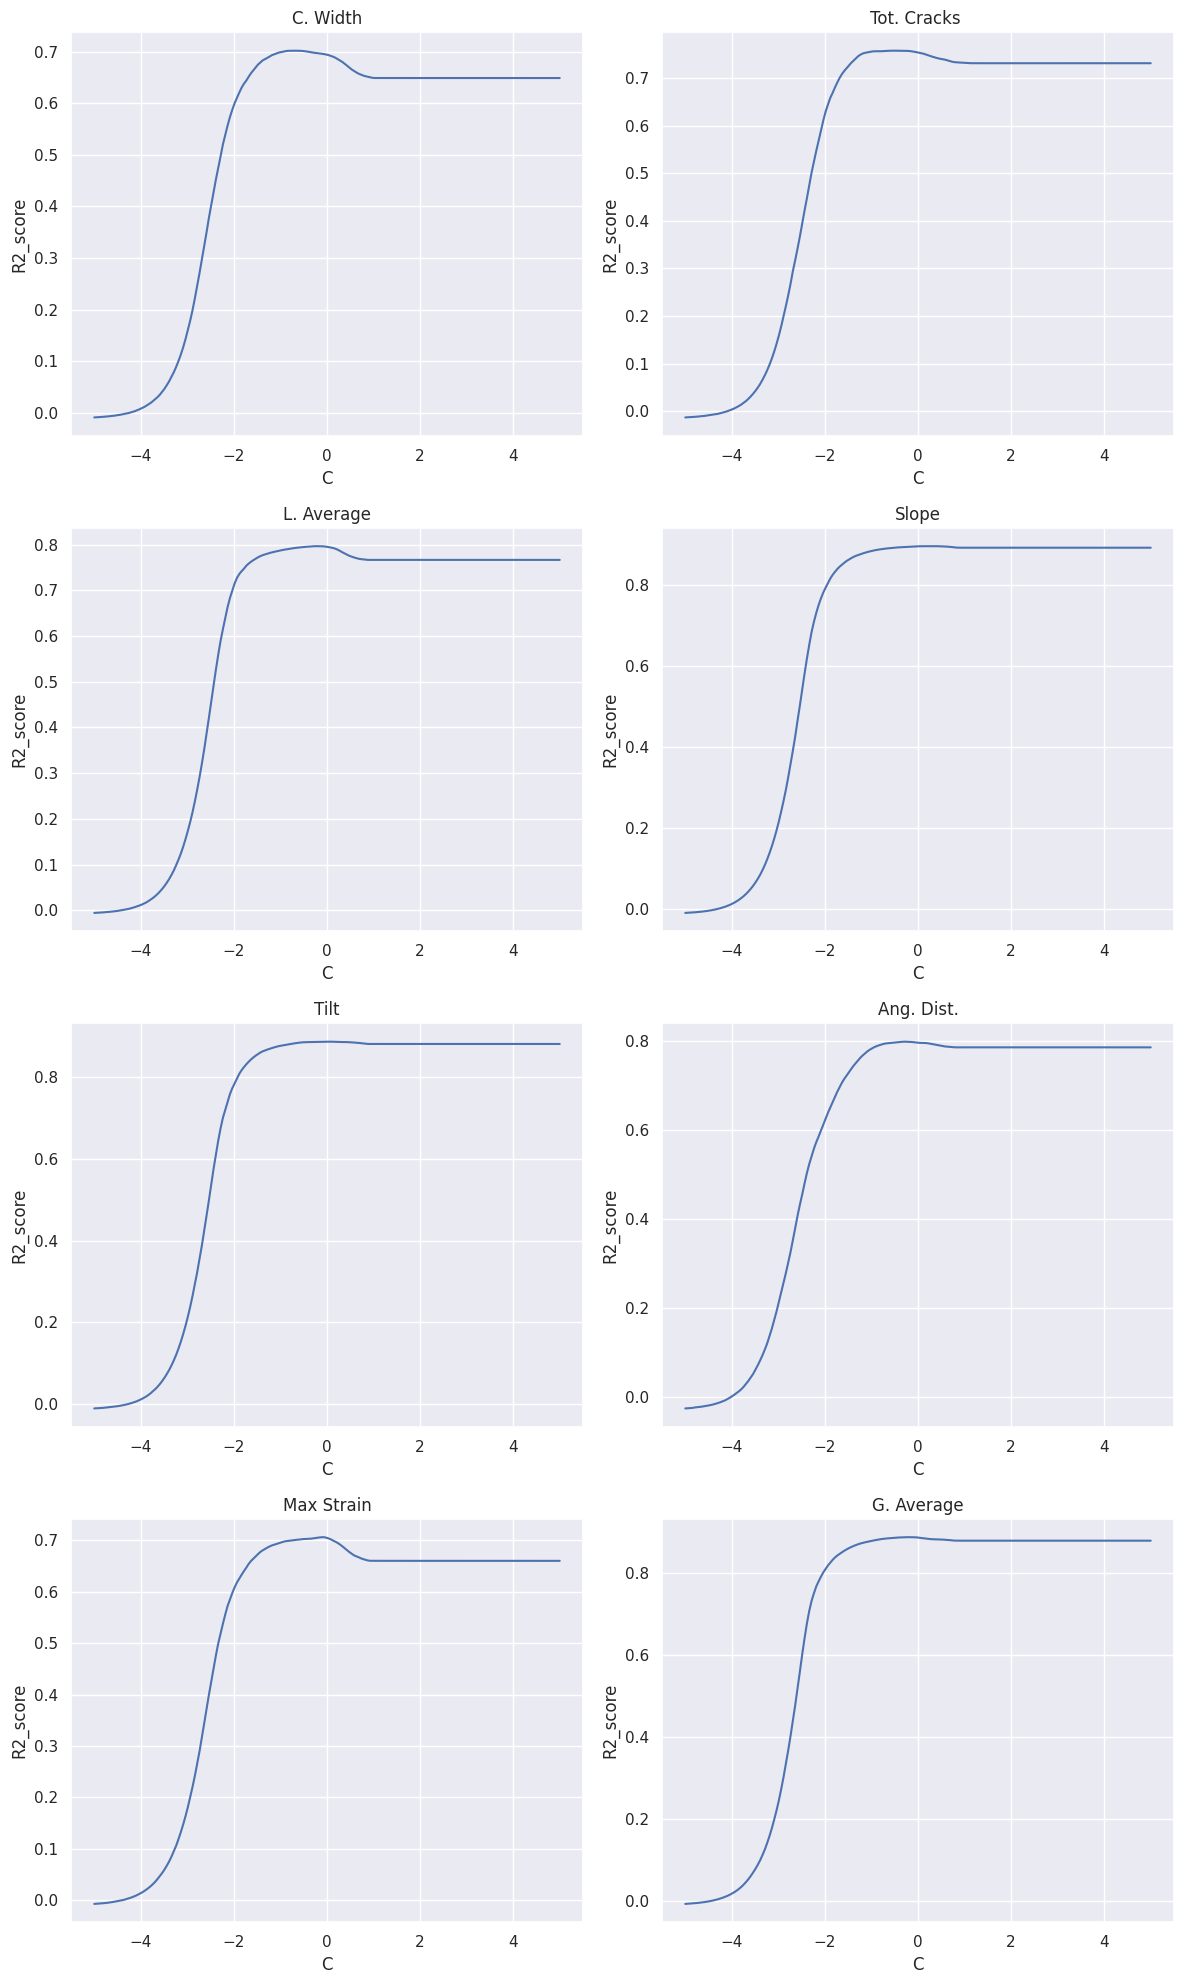

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Створення масиву значень x в заданому діапазоні
x_values = np.linspace(-5, 5, 200)  # Генерування 100 значень між 0.01 та 1
df = pd.DataFrame(x_values, columns = ['C'])
fig, axs = plt.subplots(4, 2, figsize=(12, 20))

# Обчислення значень функції для кожного x та зберігання результатів
for target_col, ax in zip(target_columns, axs.flat):
    y_values = []
    target = target_col
    for x in x_values:
        y = black_box_function(x)
        y_values.append(y)
    df[target] = y_values
    ax.plot(x_values, y_values)
    ax.set_title(f'{target}')
    ax.set_ylabel('R2_score')
    ax.set_xlabel('C')


df.to_excel('/content/drive/MyDrive/Master/C_output.xlsx')
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Master/C_plot.png', dpi=300)

#### BayesSearch

In [ ]:
!pip install bayesian-optimization

In [ ]:
from bayes_opt import UtilityFunction
from bayes_opt import SequentialDomainReductionTransformer
from bayes_opt import BayesianOptimization

# Bounded region of parameter space
pbounds = {
    'nu' : [0.001, 1],
}

bounds_transformer = SequentialDomainReductionTransformer(minimum_window=1e-03)
# UtilityFunction(kind="ucb", kappa=0.1), # Prefer exploitation
# UtilityFunction(kind="ucb", kappa=10), # Prefer exploration
# UtilityFunction(kind="ei", xi=1e-4), # Prefer exploitation
# UtilityFunction(kind="ei", xi=1e-1), # Prefer exploration
# UtilityFunction(kind="poi", xi=1e-4), # Prefer exploitation
# UtilityFunction(kind="poi", xi=1e-1) # Prefer exploration

optim = BayesianOptimization(
  f=black_box_function,
  pbounds=pbounds,
  random_state=42,
  allow_duplicate_points=True,
  bounds_transformer=bounds_transformer,
)

optim.maximize(
    init_points=5,
    n_iter=100,
    acquisition_function=UtilityFunction(kind="ei", xi=1e-1),
)

|   iter    |  target   |     C     |    nu     |
-------------------------------------------------
| 1         | 0.7807    | -1.255    | 0.9508    |
| 2         | 0.7665    | 2.32      | 0.5991    |
| 3         | -0.215    | -3.44     | 0.1568    |
| 4         | -0.2463   | -4.419    | 0.8663    |
| 5         | 0.7665    | 1.011     | 0.7084    |
| 6         | 0.7665    | 5.0       | 1.0       |
| 7         | 0.7667    | 4.101     | 0.001     |
| 8         | -1.069    | -0.3035   | 0.001     |
| 9         | 0.777     | -1.333    | 0.9295    |
| 10        | 0.7665    | 3.652     | 1.0       |
| 11        | 0.7667    | 3.08      | 0.001     |
| 12        | 0.7639    | 1.673     | 0.001     |
| 13        | 0.7666    | 4.983     | 0.02537   |
| 14        | 0.7665    | 1.634     | 1.0       |
| 15        | 0.5826    | -2.367    | 1.0       |
| 16        | 0.7665    | 4.375     | 0.7063    |
| 17        | 0.7665    | 2.878     | 1.0       |
| 18        | 0.7731    | 0.5432    | 1.0       |


In [ ]:
optim.res

[{'target': 0.7806697810535784,
  'params': {'C': -1.254598811526375, 'nu': 0.9507635921035062}},
 {'target': 0.7665487875114281,
  'params': {'C': 2.3199394181140507, 'nu': 0.5990598257128396}},
 {'target': -0.21495214180858063,
  'params': {'C': -3.439813595575635, 'nu': 0.15683852581586644}},
 {'target': -0.24629148053453886,
  'params': {'C': -4.419163878318005, 'nu': 0.8663099696291603}},
 {'target': 0.7665153930843192,
  'params': {'C': 1.0111501174320878, 'nu': 0.7083645052182495}},
 {'target': 0.766509382032508, 'params': {'C': 4.999999999999999, 'nu': 1.0}},
 {'target': 0.7667162388780656,
  'params': {'C': 4.101222609796025, 'nu': 0.001}},
 {'target': -1.0694643945683793,
  'params': {'C': -0.30351052713537474, 'nu': 0.001}},
 {'target': 0.7770031333845072,
  'params': {'C': -1.3333157721296587, 'nu': 0.9294747954491527}},
 {'target': 0.7664945159877488,
  'params': {'C': 3.6521440793991102, 'nu': 1.0}},
 {'target': 0.7667162388781443,
  'params': {'C': 3.08034096809523, 'nu'

In [ ]:
optim.max

{'target': 0.7806697810535784,
 'params': {'C': -1.254598811526375, 'nu': 0.9507635921035062}}